In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

In [2]:
%run 02_Pandas_missing_extension.ipynb

/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


### Plots configurations

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula='temp ~ ozone ',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Thu, 20 Apr 2023",Prob (F-statistic):,2.93e-18
Time:,19:17:47,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula='temp ~ ozone + solar_r ',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Thu, 20 Apr 2023",Prob (F-statistic):,1.47e-16
Time:,19:17:47,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


In [7]:
survival_df = sm.datasets.get_rdataset('flchain','survival').data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


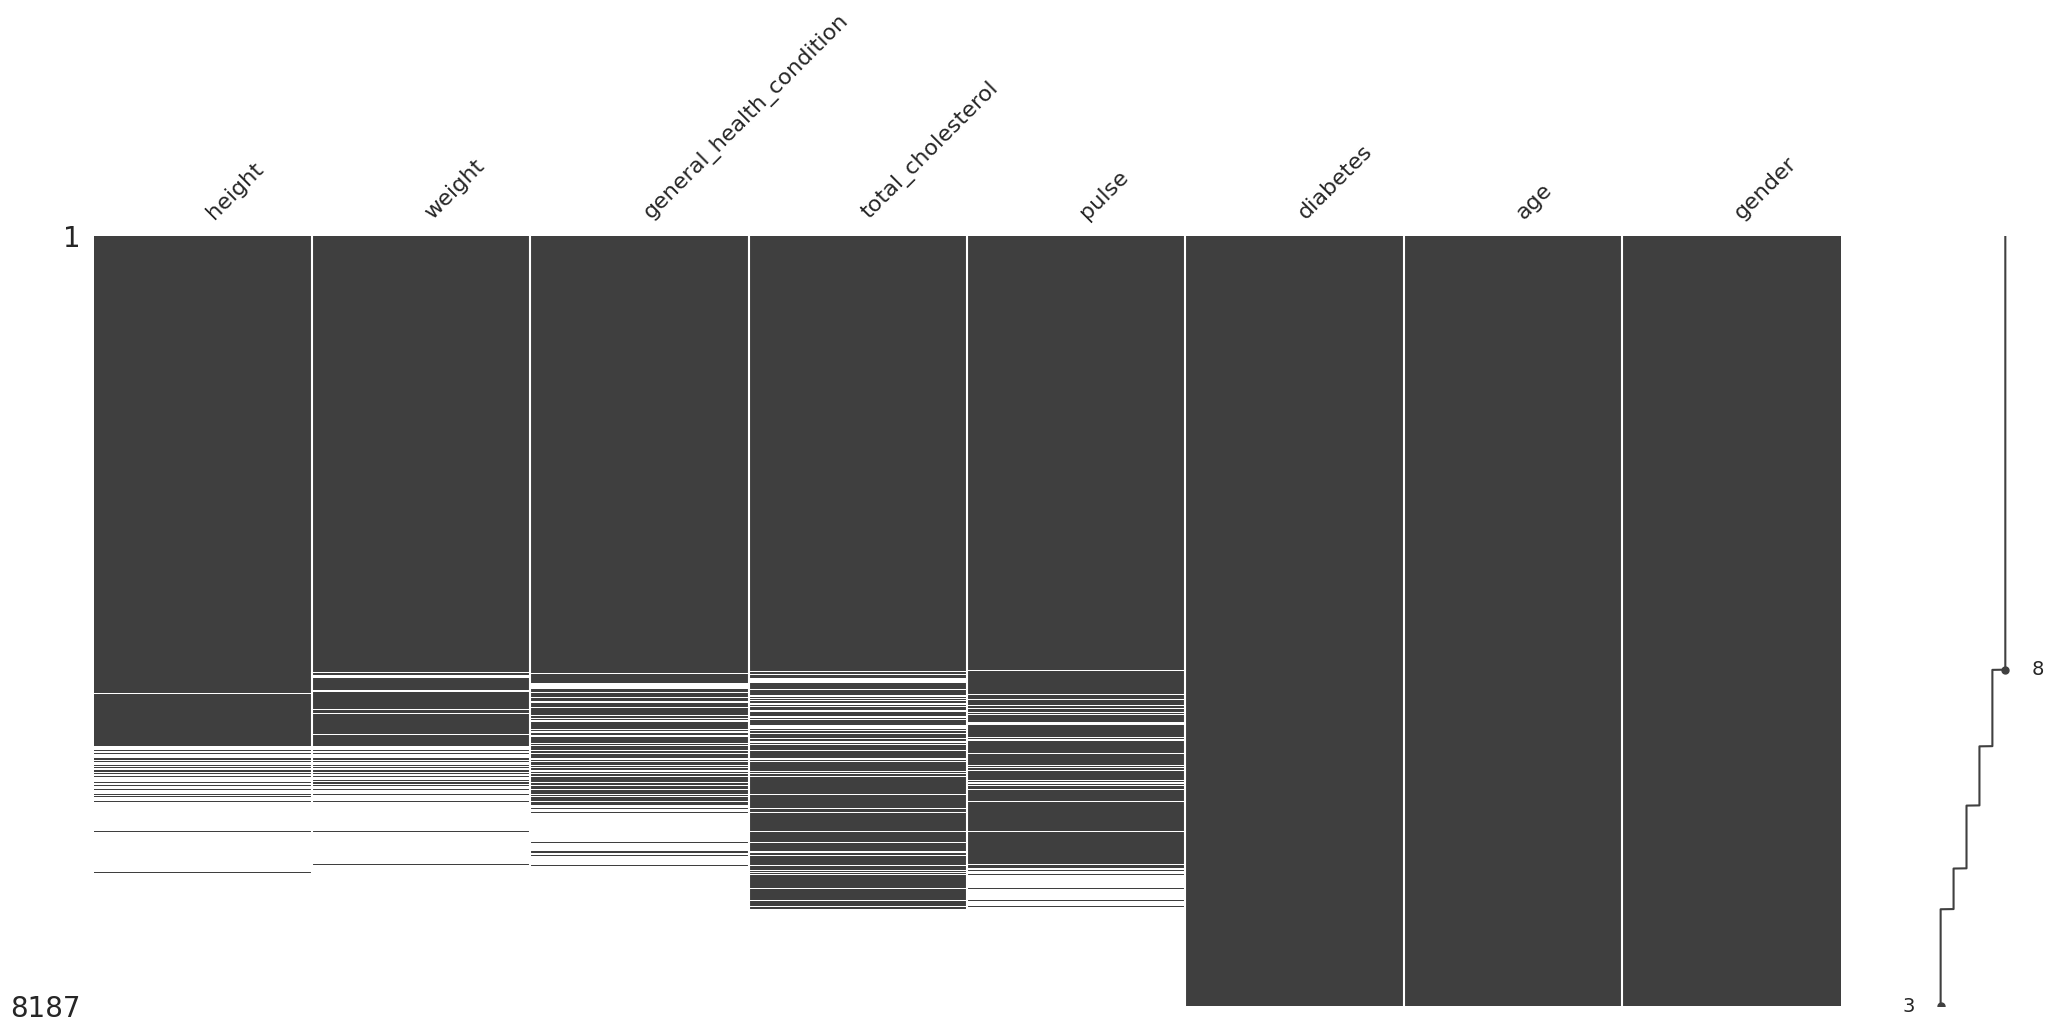

/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
/home/sayin/Data_Analyst/data_missing_imputation/env/lib/python3.10/site-packages/upsetplot/plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


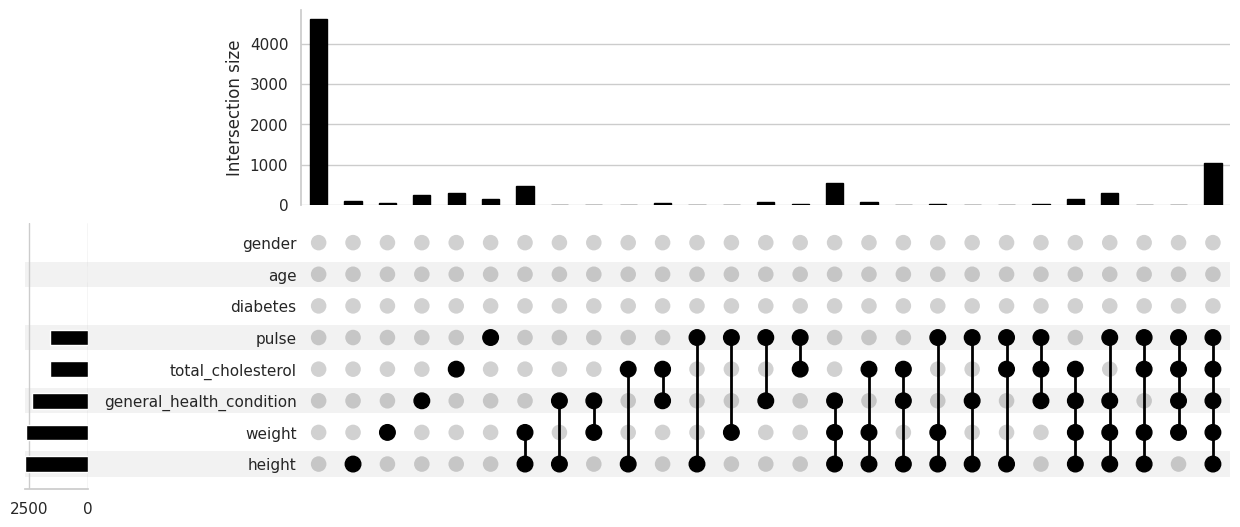

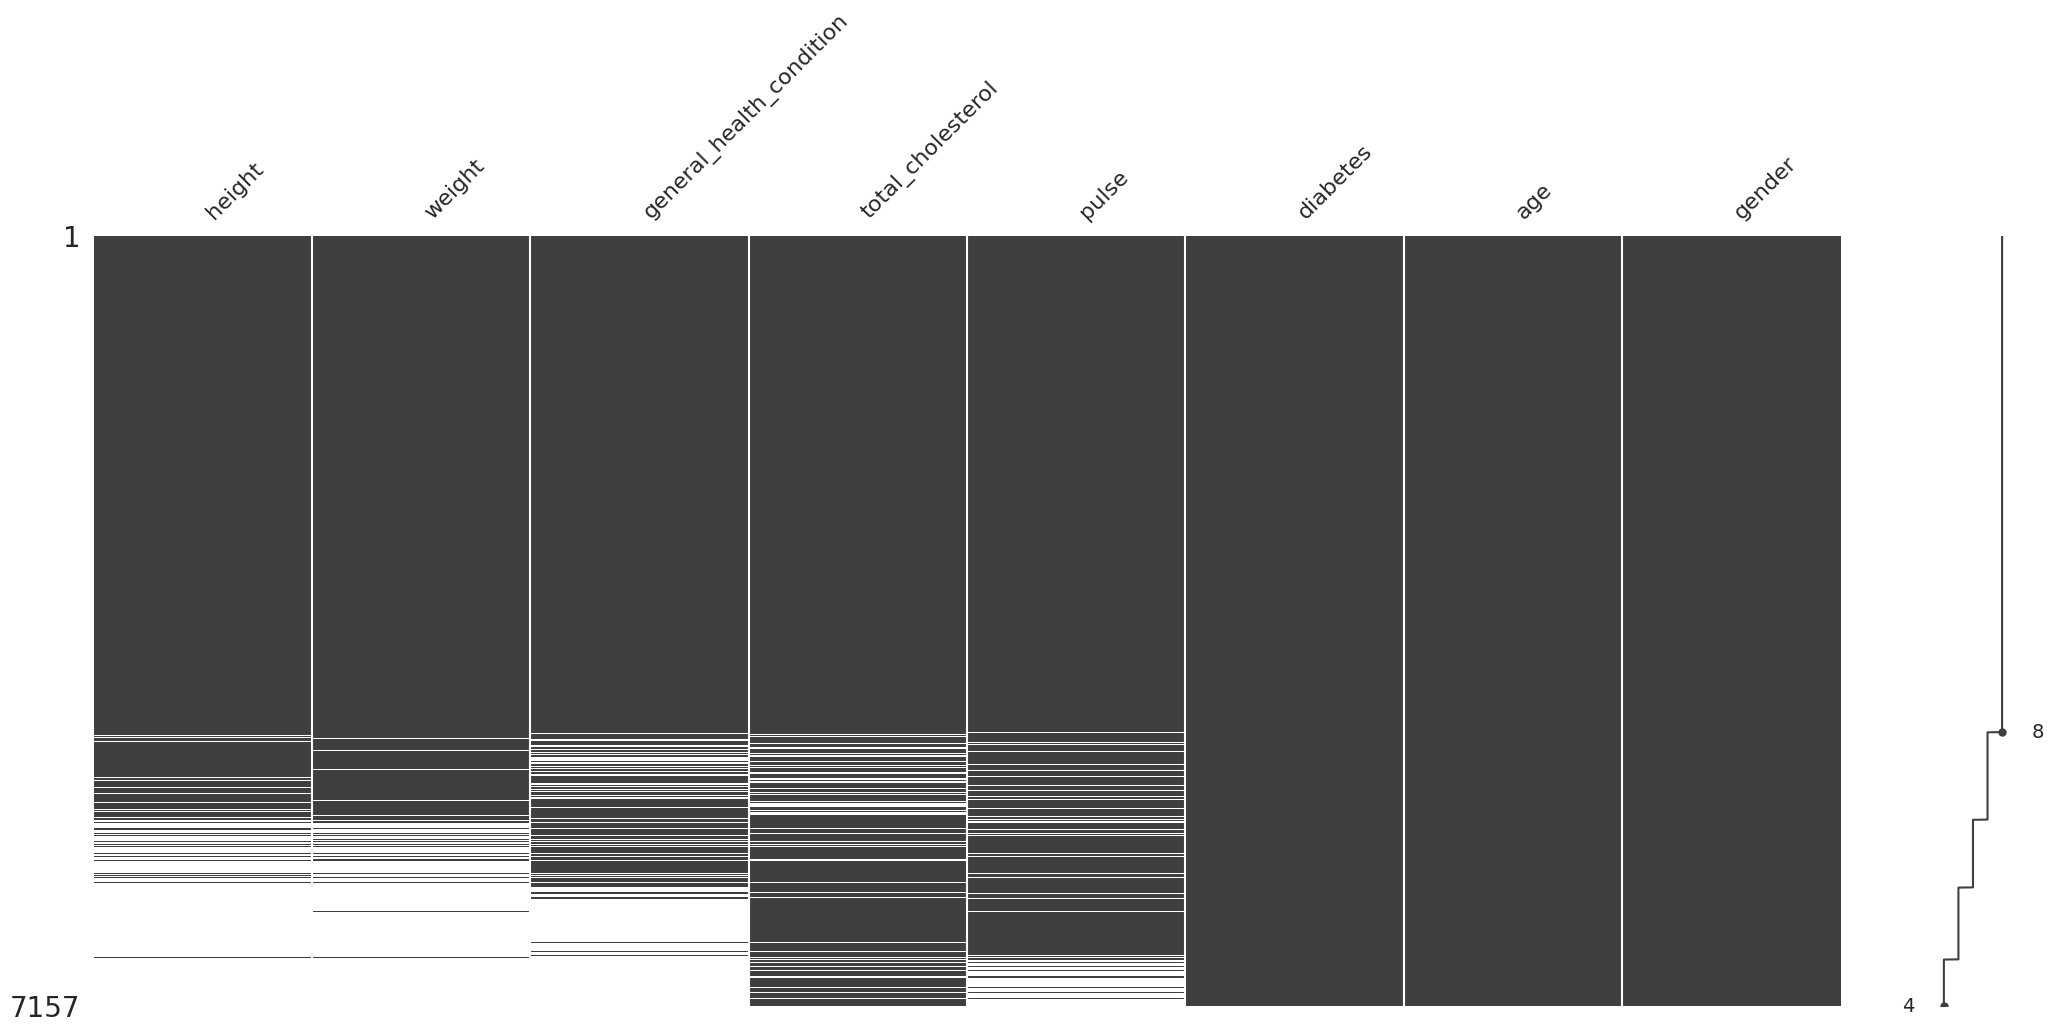

In [8]:
%run 03_Download_data_and_load_it.ipynb

### t-test

In [9]:
female_weight, male_weight = (
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x:x.isna(),
        elementwise = False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df:(
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative='two-sided'
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

### Missign values

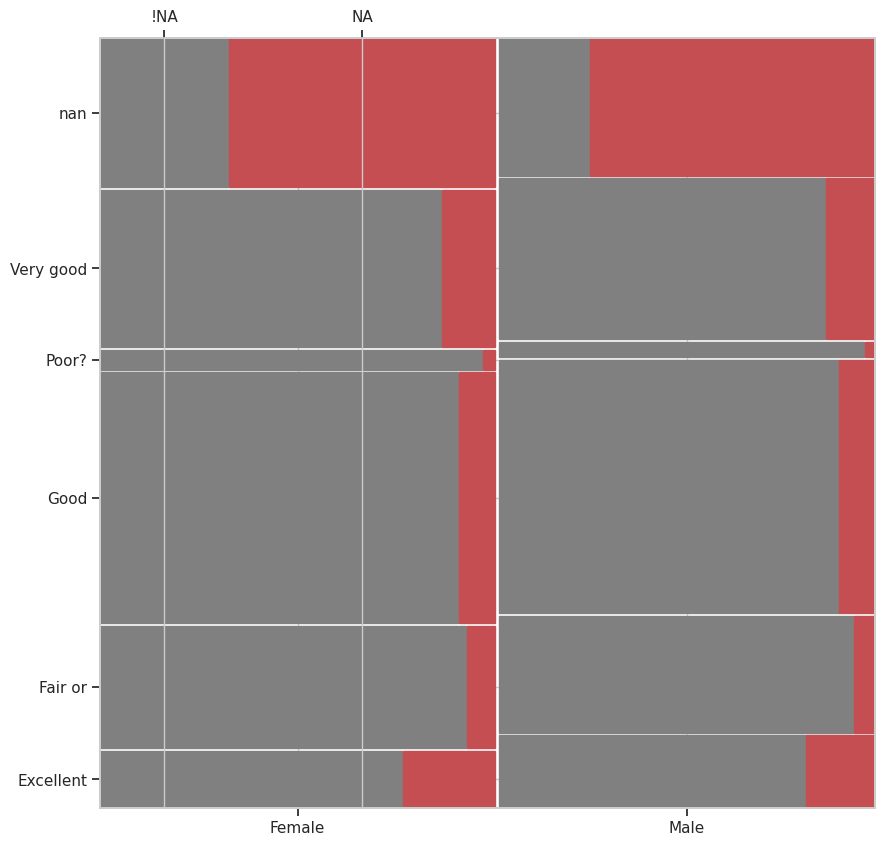

In [10]:
fig,ax = plt.subplots(figsize = (10,10))

(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True,False],['NA', '!NA'])
    )
    .groupby(
        ["gender", "general_health_condition", "weight"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data= df,
            properties= lambda key : {"color": "r" if "NA" in key else "gray"},
            horizontal= True,
            axes_label=True,
            title='',
            labelizer=lambda key: '',
            ax = ax
        )
    )
);

### Missign category values imputation 

In [11]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

In [12]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [['Male'],['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [13]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [14]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [15]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

### Data

In [16]:
categorical_columns = nhanes_df.select_dtypes(include=[object,'category']).columns

In [17]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'
)

In [18]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns= categorical_transformer.get_feature_names_out(),
        index= nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


### One hot encoding

In [19]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

In [20]:
(
    nhanes_transformed_df2
    .select_columns('general_health_condition')
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


In [21]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),['gender']),
    (sklearn.preprocessing.OneHotEncoder(),['general_health_condition']),
    remainder = 'passthrough'
)

In [22]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns= transformer.get_feature_names_out(),
        index= nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__')
    )
)
nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [23]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [24]:
(
    transformer
    .named_transformers_
    .get('onehotencoder')
    .inverse_transform(
        X= [[0,0,1,0,0,0]]
    )
)

array([['Good']], dtype=object)

### Imputation of the unique value

In [25]:
(
    nhanes_df
    .transform_column(
        'height',
        lambda x:x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676386

In [26]:
(
    nhanes_df
    .select_columns('height','weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .height
    .mean()
)

66.25655976676386

<AxesSubplot: xlabel='height', ylabel='weight'>

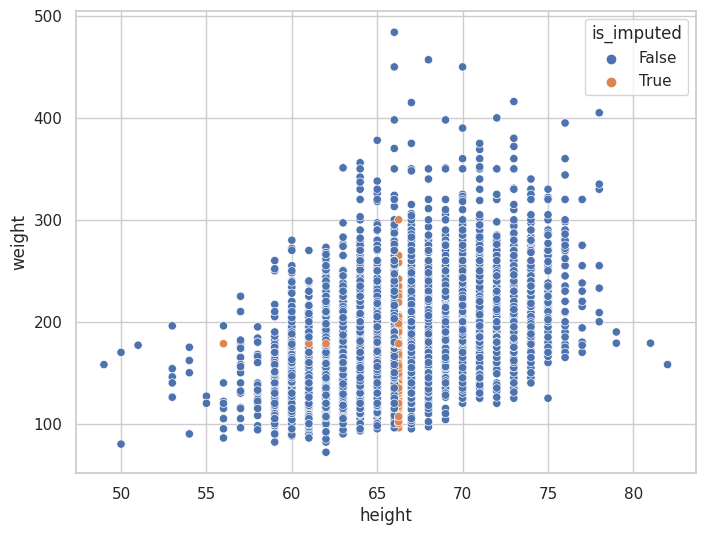

In [27]:
(
    nhanes_df
    .select_columns('height','weight')
    .missing.bind_shadow_matrix(True, False, suffix='_imp')
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(x='height', y='weight')
)

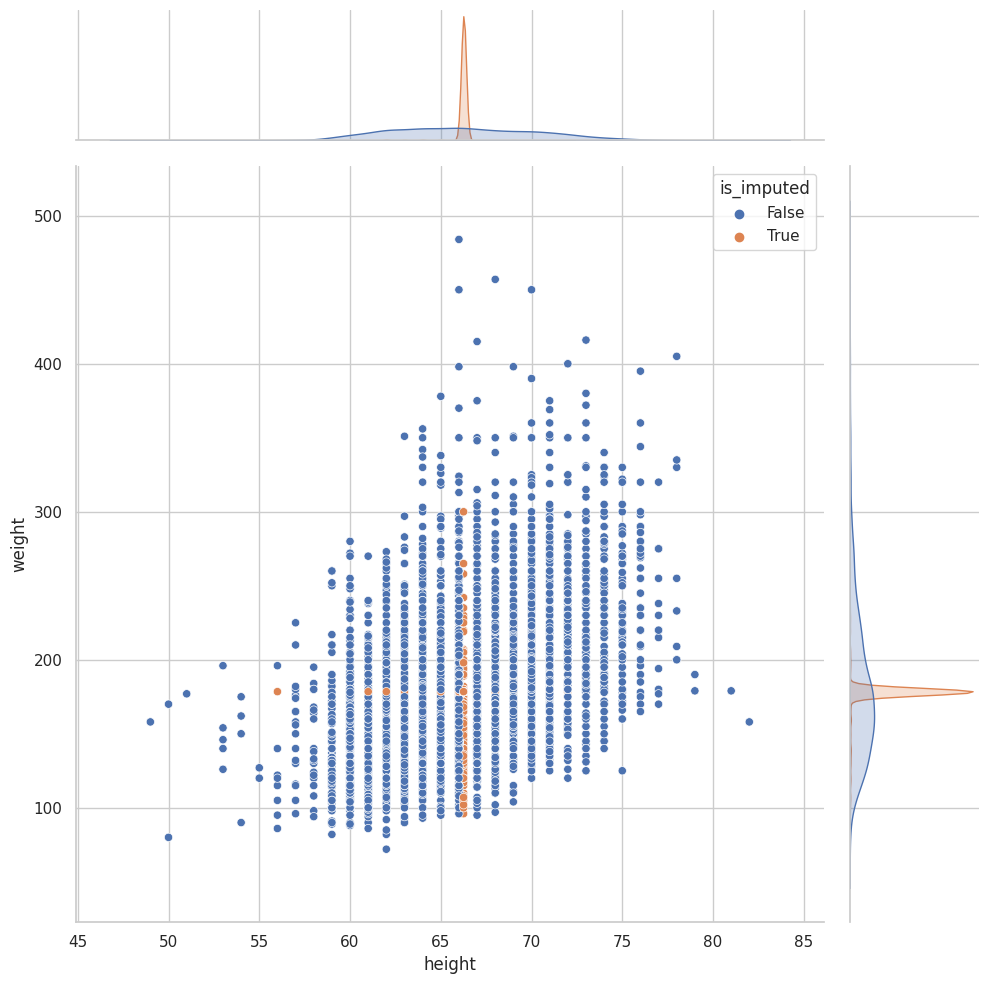

In [28]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mean()),
        weight=lambda df: df.weight.fillna(value=df.weight.mean()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

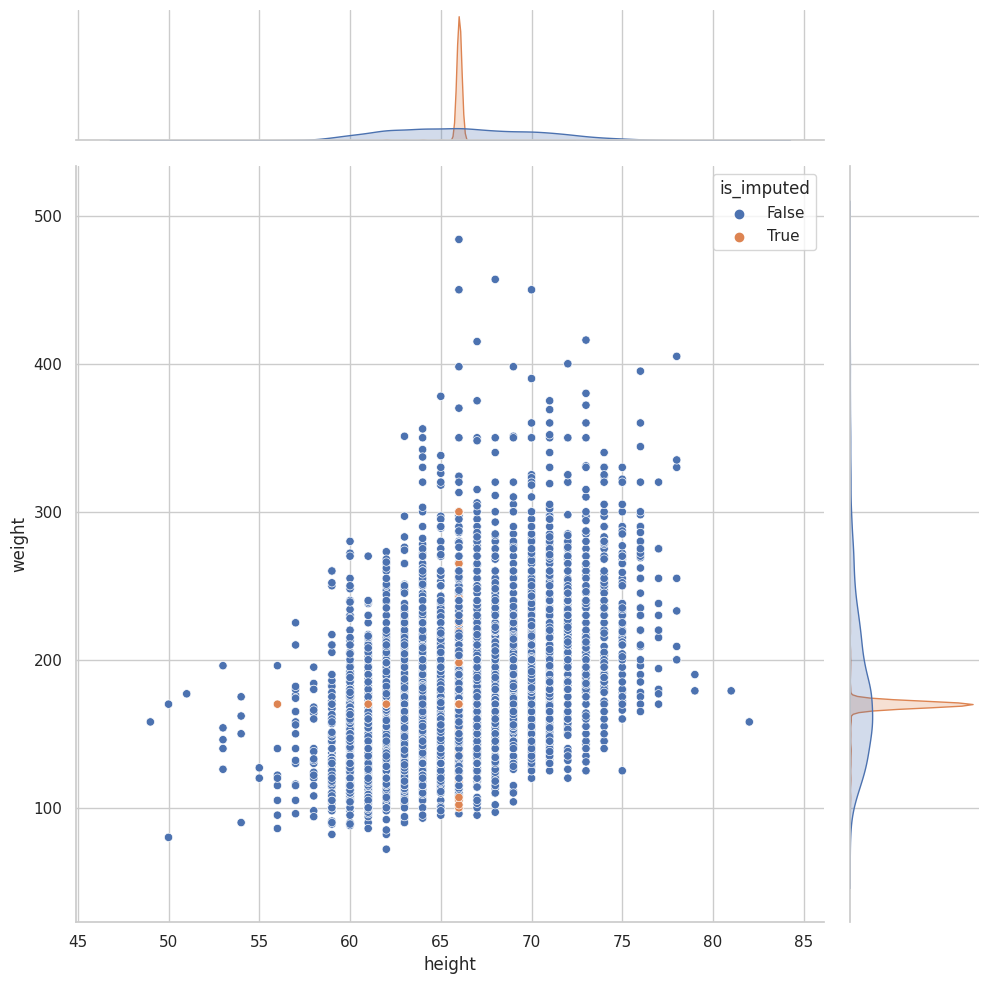

In [29]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.median()),
        weight=lambda df: df.weight.fillna(value=df.weight.median()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

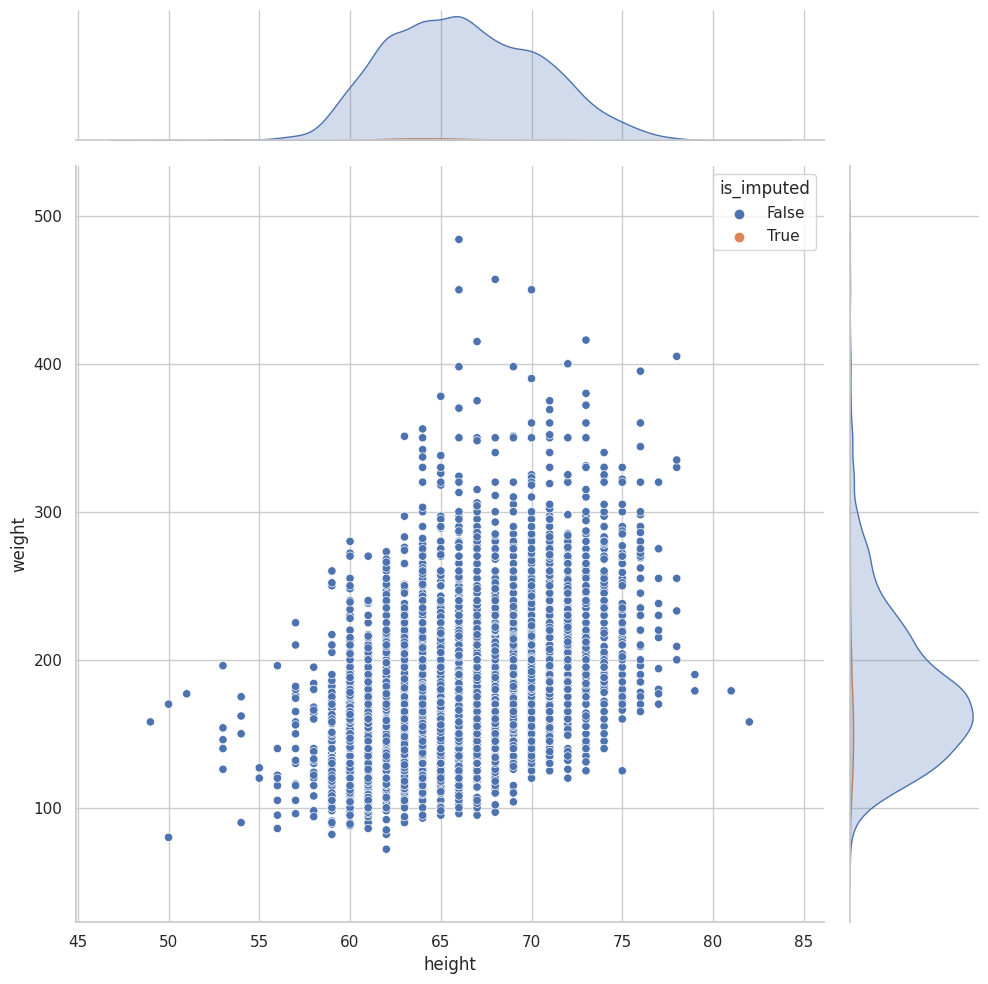

In [30]:
(
    nhanes_df.select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix="_imp")
    .assign(
        height=lambda df: df.height.fillna(value=df.height.mode()),
        weight=lambda df: df.weight.fillna(value=df.weight.mode()),
    )
    .missing.scatter_imputation_plot(
        x="height",
        y="weight",
        show_marginal=True,
        height=10
    )
)

### Another way of imputation

In [31]:
(
    nhanes_df
    .select_columns('height','weight')
    # .fillna(method='ffill')
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [32]:
(
    nhanes_df
    .select_columns('height','weight')
    # .fillna(method='bfill')
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [33]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=[ "weight", "gender", "diabetes", "general_health_condition","height"],
        ascending = True
    )
    .transform_column(
        'weight',
        lambda x:x.ffill(),
        elementwise=False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
99970.0,62.0,72.0,Male,0,Good
97877.0,50.0,80.0,Female,0,NaN
96451.0,59.0,82.0,Female,0,Good
97730.0,62.0,82.0,Female,0,Good
99828.0,62.0,85.0,Female,0,Very good
...,...,...,...,...,...
102166.0,NaN,484.0,Male,1,Good
95978.0,72.0,484.0,Male,1,Very good
97267.0,NaN,484.0,Male,1,NaN


###  Interpolation Imputation

<AxesSubplot: xlabel='date'>

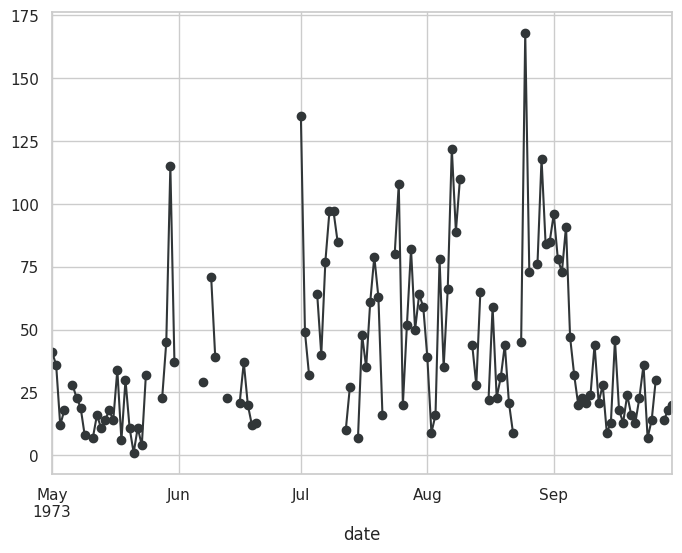

In [34]:
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

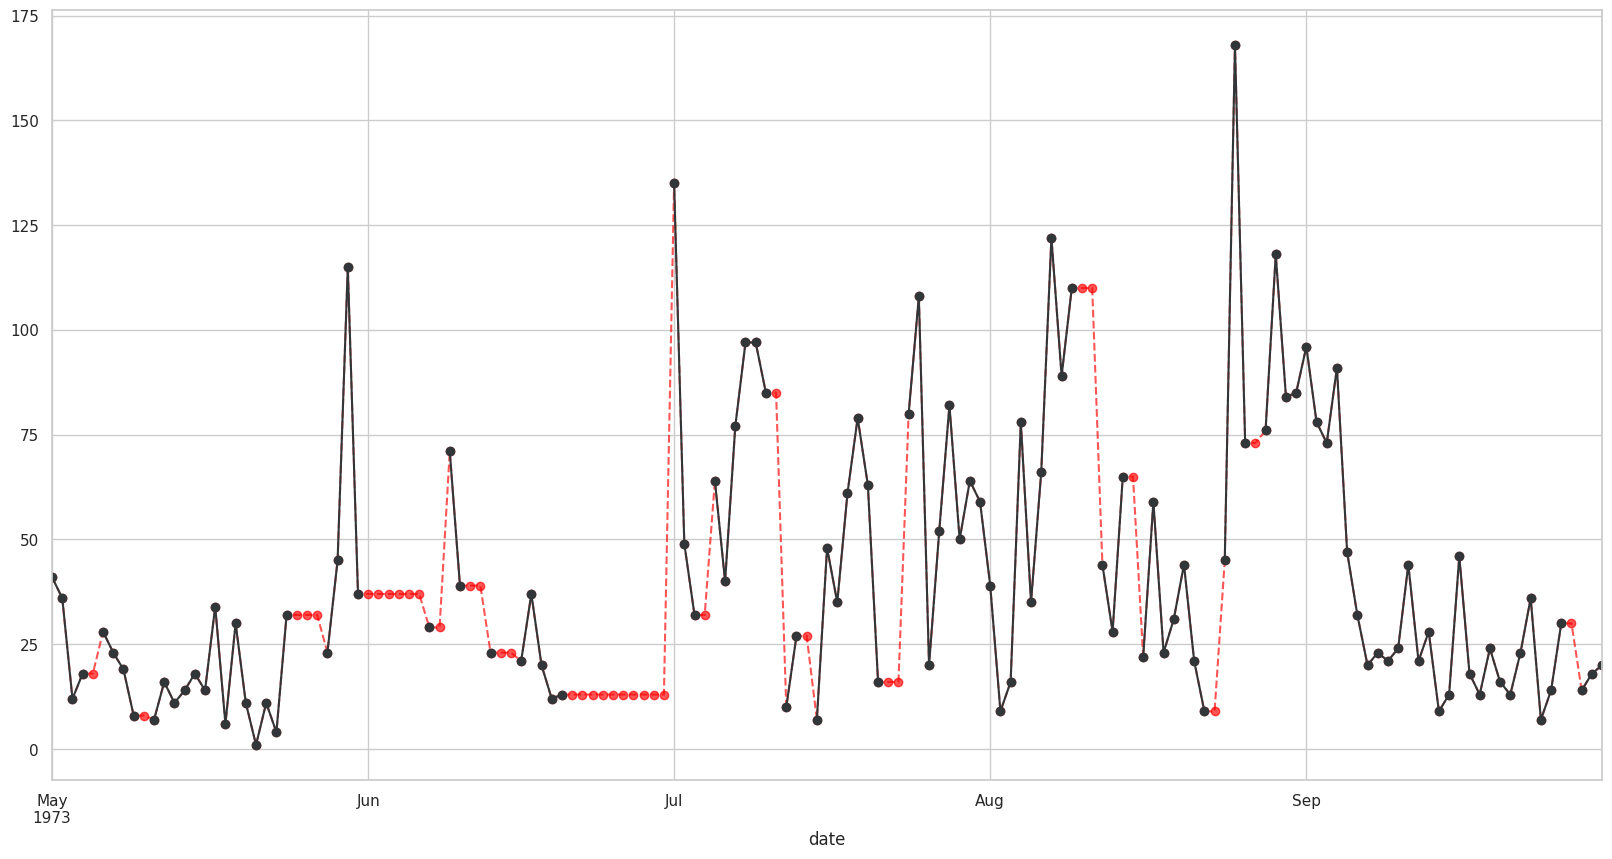

In [35]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.ffill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

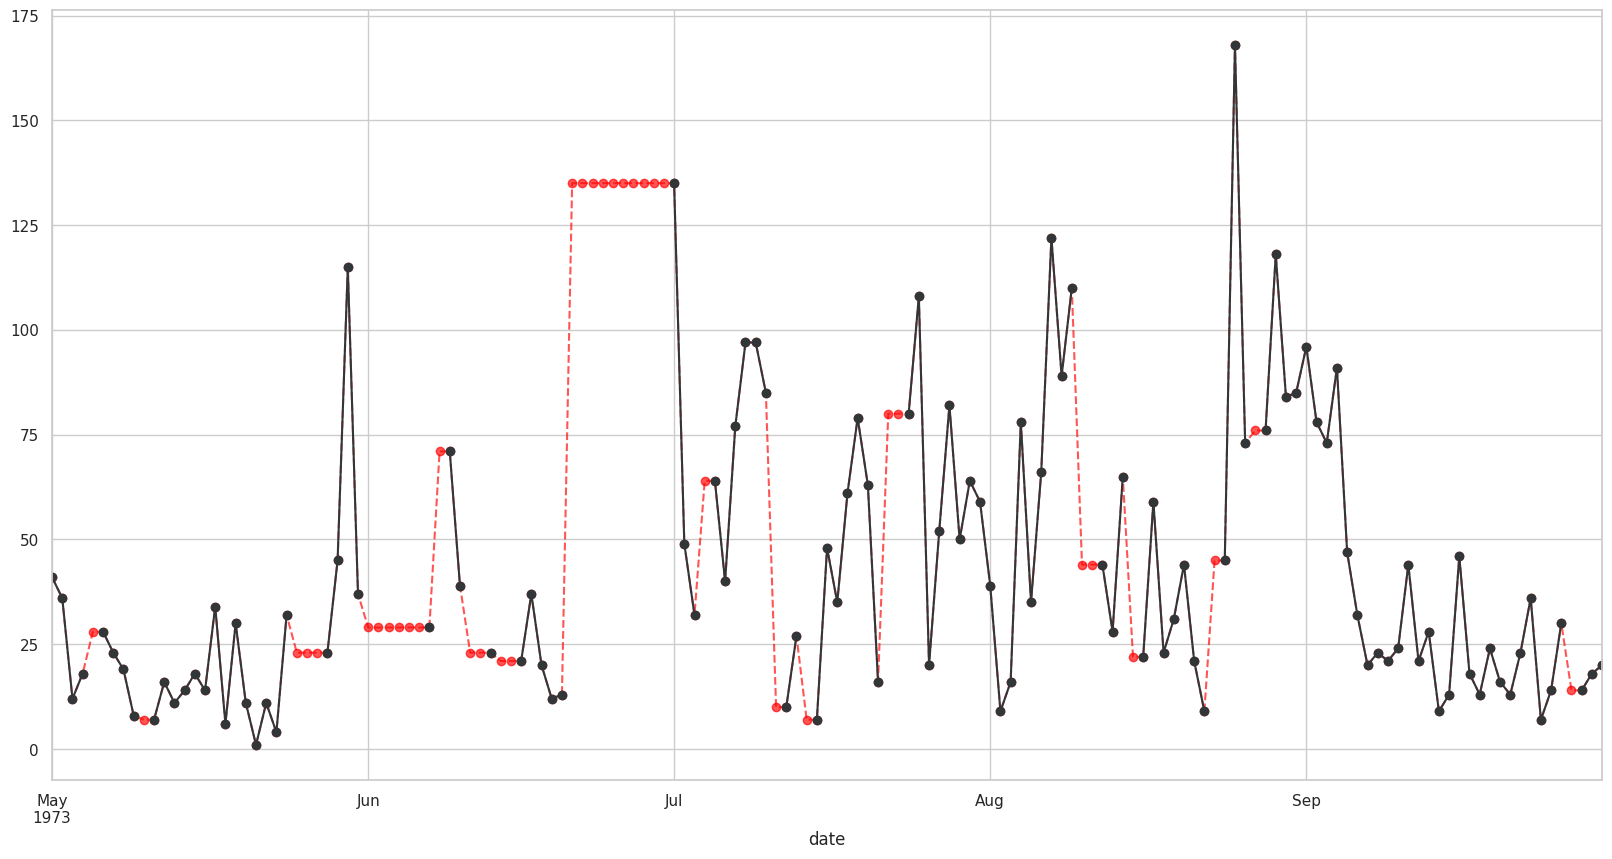

In [36]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.bfill().plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

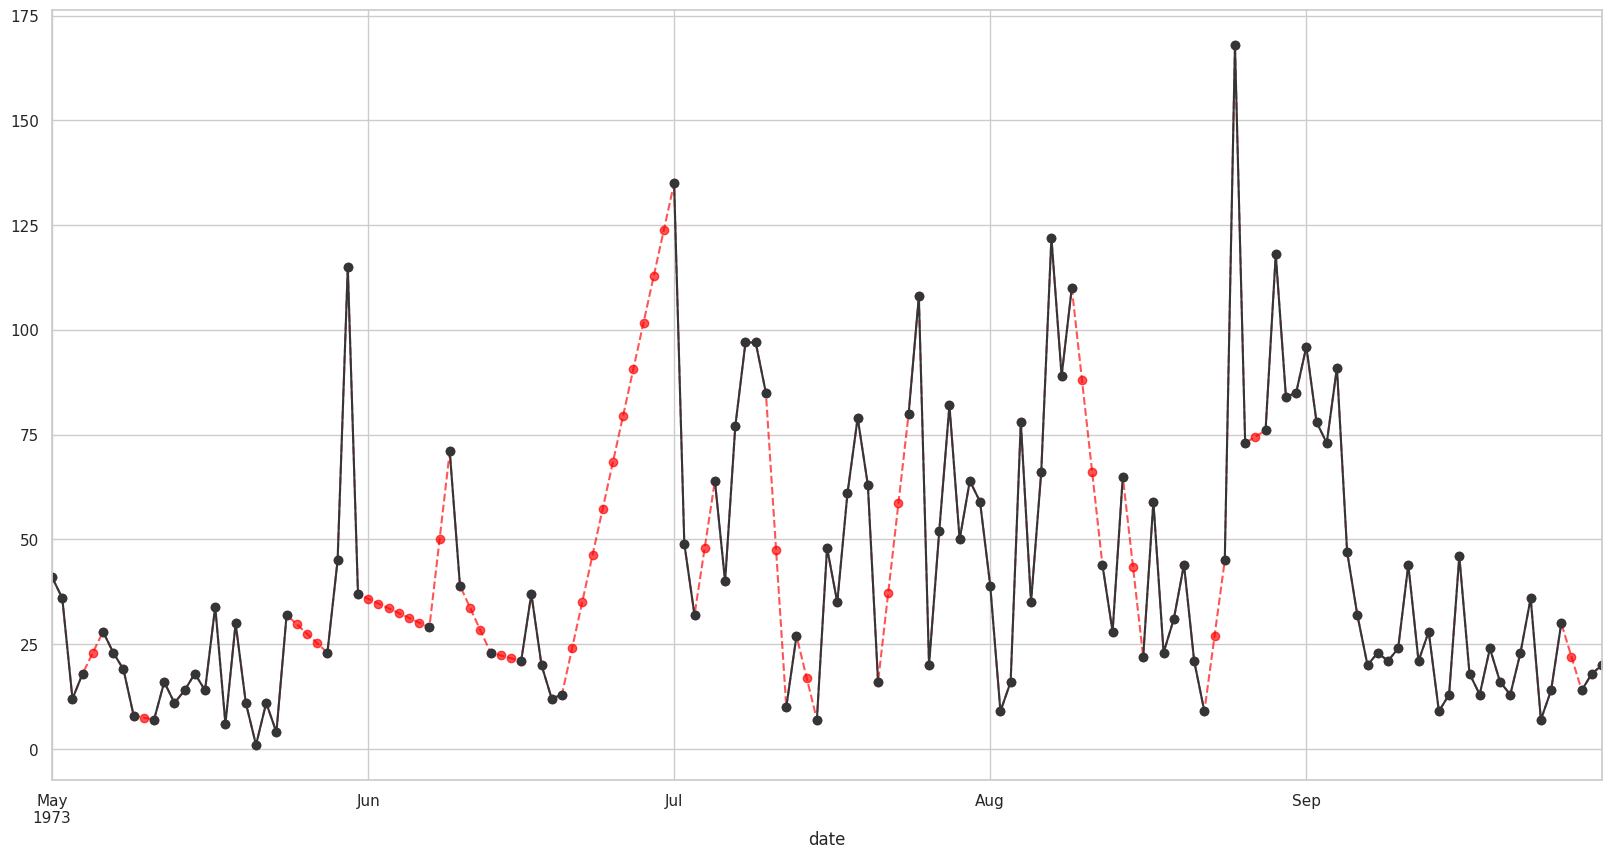

In [37]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

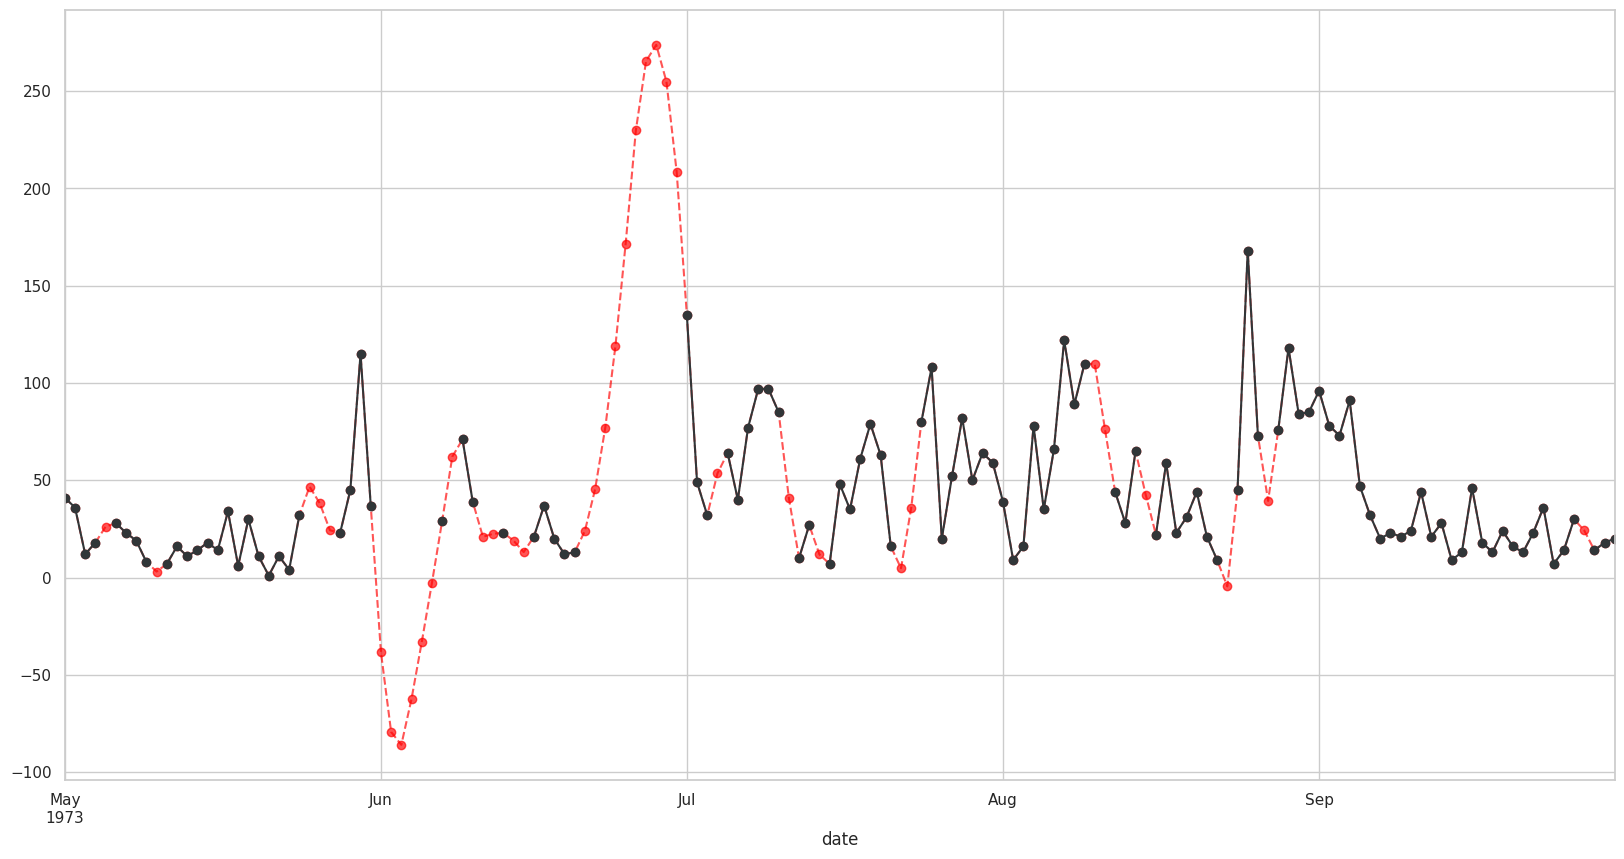

In [38]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.interpolate(method = "quadratic").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

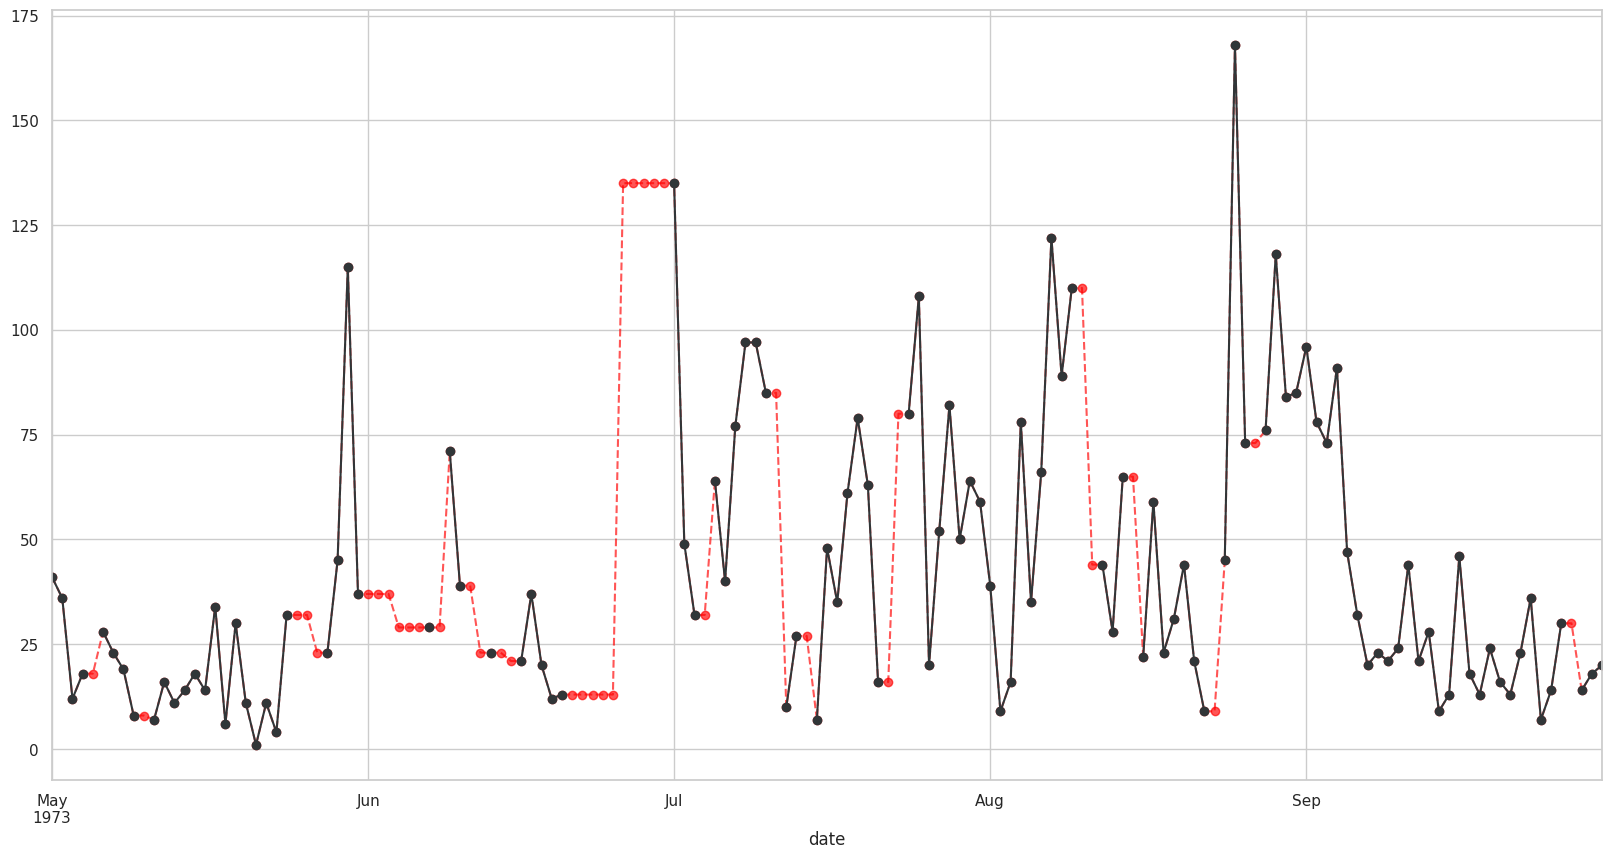

In [39]:
plt.figure(figsize=(20,10))

(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df:(
            df.ozone.interpolate(method = "nearest").plot(color = "red", marker = "o", alpha=6/9, linestyle = "dashed"),
            df.ozone.plot(color = "#313638", marker = "o")
        )
    )
)

In [40]:
airquality_df['ozone'] = airquality_df.ozone.interpolate(method='linear')

In [41]:
airquality_df['ozone'].isna().sum()

0

### Imputation KNN

In [43]:
nhanes_df

,height,weight,general_health_condition,total_cholesterol,pulse,diabetes,age,gender
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,66.0,Female
93706.0,68.0,145.0,Very good,148.0,82.0,0,18.0,Male
93707.0,NaN,NaN,Good,189.0,100.0,0,13.0,Male
93709.0,62.0,200.0,NaN,176.0,74.0,0,75.0,Female
93711.0,69.0,142.0,Very good,238.0,62.0,0,56.0,Male
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,33.0,Male
102953.0,65.0,218.0,Fair or,182.0,78.0,0,42.0,Male
102954.0,66.0,150.0,Good,172.0,78.0,0,41.0,Female


In [44]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [48]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,69.0,130.0,189.0,100.0,0.0,13.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


<AxesSubplot: xlabel='height', ylabel='weight'>

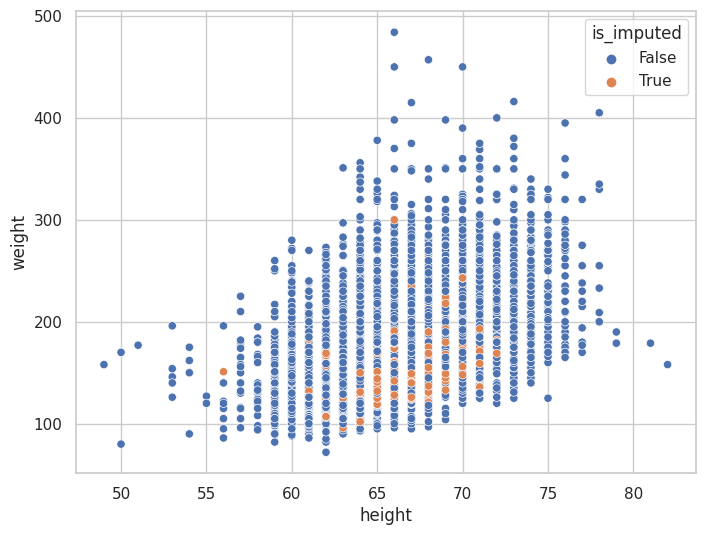

In [50]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True,False,suffix='_imp', only_missing=True)
            
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
)

In [51]:
knn_imputer = sklearn.impute.KNNImputer()
nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:, :] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()
nhanes_df_knn

,gender,diabetes,age,pulse,total_cholesterol,general_health_condition,weight,height
SEQN,,,,,,,,
93705.0,0.0,0.0,66.0,52.0,157.0,2.0,165.0,63.0
93706.0,1.0,0.0,18.0,82.0,148.0,4.0,145.0,68.0
93707.0,1.0,0.0,13.0,100.0,189.0,2.0,130.0,69.0
93709.0,0.0,0.0,75.0,74.0,176.0,2.0,200.0,62.0
93711.0,1.0,0.0,56.0,62.0,238.0,4.0,142.0,69.0
...,...,...,...,...,...,...,...,...
102949.0,1.0,0.0,33.0,96.0,201.0,0.0,180.0,72.0
102953.0,1.0,0.0,42.0,78.0,182.0,1.0,218.0,65.0
102954.0,0.0,0.0,41.0,78.0,172.0,2.0,150.0,66.0


<AxesSubplot: xlabel='height', ylabel='weight'>

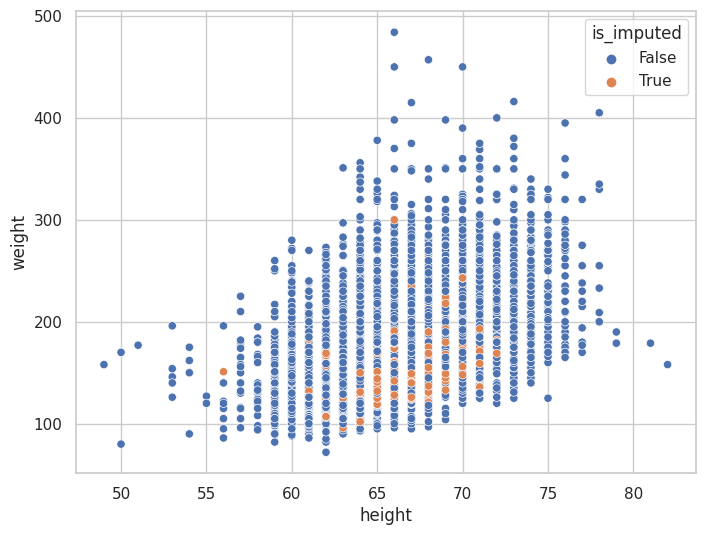

In [52]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True,False,suffix='_imp', only_missing=True)
            
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
)

### Base on models imputation 

In [70]:
nhanes_model_df =(
    nhanes_df
    .select_columns("height", "weight", "gender", "age")
    .sort_values(by='height')
    .transform_column(
        'weight',
        lambda x:x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp',
        only_missing=False
    )
)
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [71]:
height_ols=(
    nhanes_model_df
    .pipe(
        lambda df: smf.ols('height ~ weight + gender + age', data=df)
    )
    .fit()
)

In [72]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)
ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [73]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


<AxesSubplot: xlabel='weight', ylabel='height'>

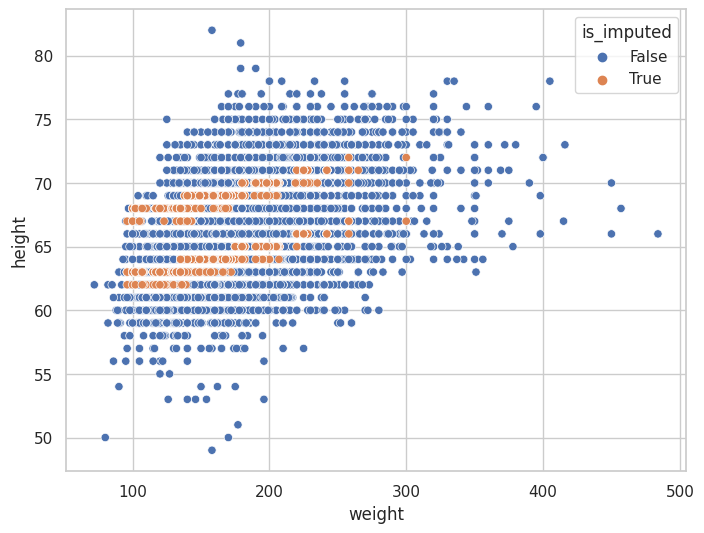

In [74]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x = 'weight',
        y = 'height'
    )
)

### Mice Imputation

<AxesSubplot: xlabel='height', ylabel='weight'>

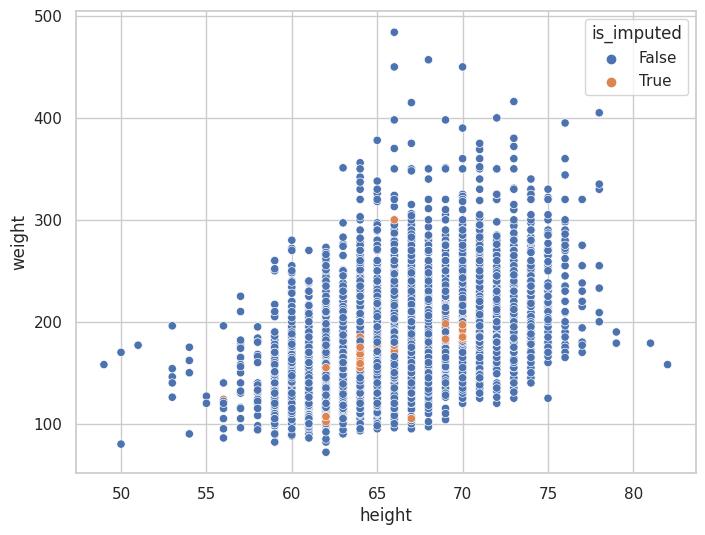

In [80]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending',
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

nhanes_mice_df.iloc[:, :] = mice_imputer.fit_transform(nhanes_transformed_df).round()

nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(
        True,
        False,
        suffix='_imp'), 
    ], 
    axis = 1  

)

nhanes_mice_df.missing.scatter_imputation_plot(
    x = 'height',
    y = 'weight'
)